# Modeling of void fraction in fluid channel

This notebook is designed for analysis of neutron data
which describes void fraction of refrigerant
flowing through a microfluidic channel.

Created on Thu Feb 13 10:33:13 2020  
author: ericmuckley@gmail.com

### Import libraries

In [10]:
import os
import numpy as np
from glob import glob
from time import time
import matplotlib.pyplot as plt

# change matplotlib settings to make plots look nicer
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.minor.width'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.minor.width'] = 3
plt.rcParams['ytick.major.width'] = 3

### Get image list

In [11]:
# set path of folder which contains image files
folder_path = os.path.join(os.getcwd(), 'data')
all_images = [f for f in glob(folder_path+'/*') if '.tif' in f]
print('Found {} images:'.format(len(all_images)))
for img in all_images:
    print(os.path.split(img)[1])

Found 17 images:
25lbhA0010.tif
25lbhA0020.tif
25lbhA0030.tif
25lbhA0040.tif
25lbhA0050.tif
25lbhA0060.tif
25lbhA0070.tif
75lbh000010.tif
75lbh000020.tif
75lbh000030.tif
75lbh000040.tif
75lbh000050.tif
75lbh000060.tif
75lbh000070.tif
75lbh000080.tif
75lbh000090.tif
75lbh000100.tif


### Define some functions

In [12]:
def plot_setup(labels=['X', 'Y'], fsize=18, setlimits=False,
               limits=[0,1,0,1], title='', size=None,
               legend=False, save=False, filename='plot.jpg'):
    """Creates a custom plot configuration to make graphs look nice.
    This can be called with matplotlib for setting axes labels,
    titles, axes ranges, and the font size of plot labels.
    This should be called between plt.plot() and plt.show() commands."""
    plt.xlabel(str(labels[0]), fontsize=fsize)
    plt.ylabel(str(labels[1]), fontsize=fsize)
    plt.title(title, fontsize=fsize)
    fig = plt.gcf()
    if size:
        fig.set_size_inches(size[0], size[1])
    else:
        fig.set_size_inches(10, 10)
    if legend:
        plt.legend(fontsize=fsize-4)
    if setlimits:
        plt.xlim((limits[0], limits[1]))
        plt.ylim((limits[2], limits[3]))
    if save:
        fig.savefig(filename, dpi=120, bbox_inches='tight')
        plt.tight_layout()

def plot_channel_image(image, title=None, vmin=None, vmax=None):
    """Plot image of the channel, colored by void fraction."""
    plt.imshow(image, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, )
    fig = plt.gcf()
    fig.set_size_inches(11,11)
    plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=16)
    plt.show()

### Trim empty space out of images

Here we remove the aluminum region around the channel in each
image so that the channel region is isolated.
The channel region is marked by red lines in the plots below.
After non-channel regions are trimmed away, the void faction
of each channel is calculated so that blue=0 and red=1.
Finally, we save all the images to file in a single dictionary
so they can be easily imported later.

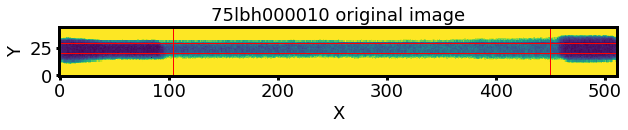

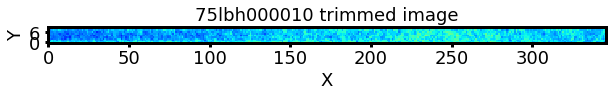

Trimmed image pixel shape: (10, 346)


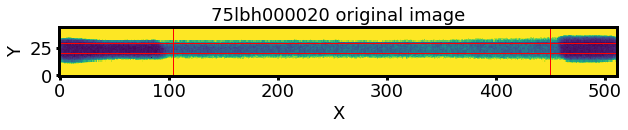

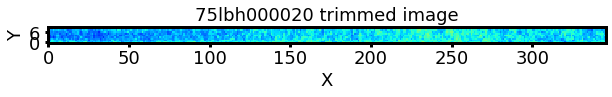

Trimmed image pixel shape: (10, 346)


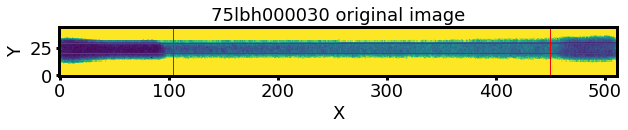

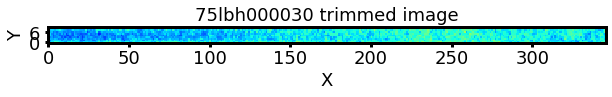

Trimmed image pixel shape: (10, 346)


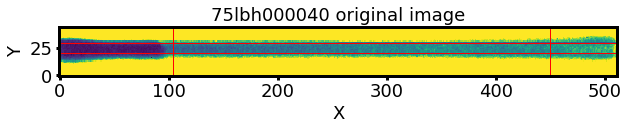

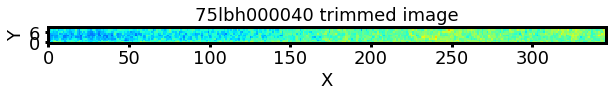

Trimmed image pixel shape: (10, 346)


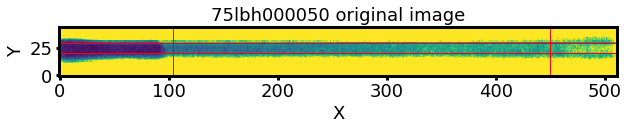

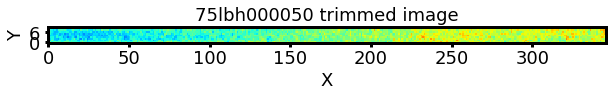

Trimmed image pixel shape: (10, 346)


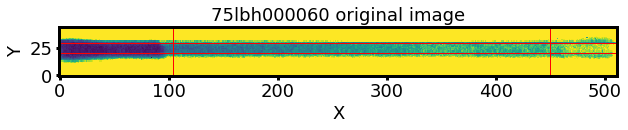

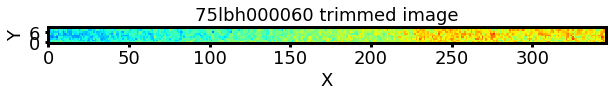

Trimmed image pixel shape: (10, 346)


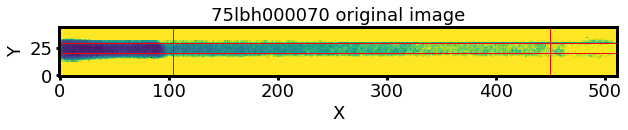

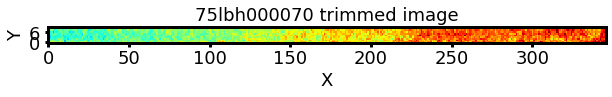

Trimmed image pixel shape: (10, 346)


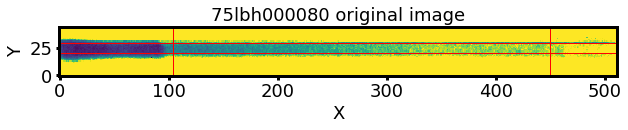

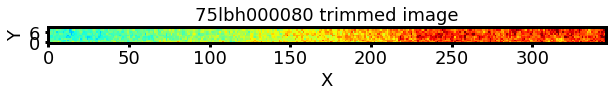

Trimmed image pixel shape: (10, 346)


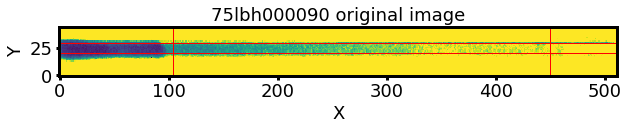

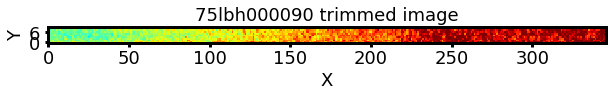

Trimmed image pixel shape: (10, 346)


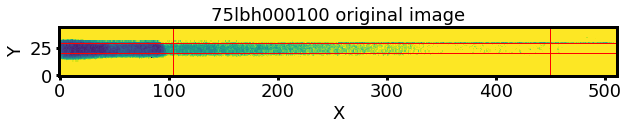

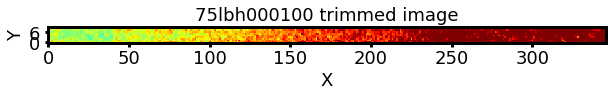

Trimmed image pixel shape: (10, 346)


In [13]:
# set vertical pixel limits that we want to select to remove aluminum area
rlims25 = [245, 280]
rlims75 = [225, 270]

# create dictionary to hold all trimmed images
img_dict = {}

# look at only 75 lb flow rate images for now
img_names = sorted([i for i in all_images if '75' in i])

# loop over each image and trim image to channel dimensions
for img in img_names:
    
    # get flowrate and temperature from image names
    label = os.path.split(img)[1].split('.')[0]
    flowrate = int(label.split('lb')[0])
    # trim image based on the flow rate so that all images are centered
    if flowrate == 25:
        img_raw = plt.imread(img)[:, :, 0].T[rlims25[0]:rlims25[1]]
        temp = int(label.split('00')[-1])
        xlims = [75, 421]
        ylims= [15, 25]
    if flowrate == 75:
        img_raw = plt.imread(img)[:, :, 0].T[rlims75[0]:rlims75[1]]
        temp = int(label.split('000')[-1])
        xlims = [104, 450]
        ylims = [20, 30]
        
    # cut image to only include channel interior
    img_channel = img_raw[ylims[0]:ylims[1], xlims[0]:xlims[1]]

    # save results into dictionary
    img_dict[label] = {
            'flowrate': flowrate,
            'temp': temp,
            'img_raw': img_raw,
            'img_channel': img_channel,
            'img_voidfrac': img_channel/255} 

    # plot results
    show_full_image = True
    show_channel_image = True
    if show_full_image:
        # plot horizontal bounding lines
        plt.axvline(x=xlims[0], color='r', lw=1)
        plt.axvline(x=xlims[1], color='r', lw=1)
        # plot vertical bounding lines
        plt.axhline(y=ylims[0], color='r', lw=1)
        plt.axhline(y=ylims[1], color='r', lw=1)
        plt.imshow(img_raw, origin='lower', vmin=0, vmax=255)
        plt.title(label)
        plot_setup(title=label+' original image')
        plt.show()
    if show_channel_image:
        plt.imshow(img_channel/255, origin='lower',
                   vmin=0, vmax=1, cmap='jet')
        plot_setup(title=label+' trimmed image')
        plt.yticks([0, 6])
        plt.show()
        print('Trimmed image pixel shape: {}'.format(np.shape(img_channel)))
    print('==============================================================')

# save trimmed channel images to numpy file
save_img_path = os.path.join(os.getcwd(), 'trimmed_images.npy')
np.save(save_img_path, img_dict)

## Model the void fraction in each channel image

Now we use Monte Carlo methods to construct possible bubble configurations
in the channel which will yield the experimentally-measured
void fraction in each image. This is carried out by beginning
with a uniform simulated channel of void fraction = 0 and incrementally
adding bubbles of stochastic positions and radii until the
void fraction in the modeled channel is equal to the void fraction
in the measured image within an error threshold.

In [14]:
def get_channel(channel_shape):
    """Return empty channel array and list of all
    index coordinates of the empty channel."""
    # create empty channel
    channel = np.zeros(channel_shape)
    # get list of ordered pairs of channel index coordinates
    yy_channel, xx_channel = np.indices(channel.shape)
    channel_coords = np.column_stack(
        (np.ravel(xx_channel), np.ravel(yy_channel)))
    return channel, channel_coords

def get_bubbles(channel, num=1000, min_rad=0, max_rad=100):
    """Get random bubble radii and center coordinates."""
    # get random radii and sort from large to small
    rad_list = np.random.uniform(min_rad, max_rad, num)
    rad_list = np.sort(rad_list)[::-1]
    # get random x- and y-positions within the channel
    x_list = np.random.uniform(0, len(channel[0]), num)
    y_list = np.random.uniform(0, len(channel), num)
    return {'rad': rad_list, 'x': x_list, 'y': y_list}

## Set parameters of the model

Here we define the physical dimensions of the channel and bubbles.

In [15]:
# define channel dimensions (width, height, depth) in μm and bubble radii limits and buffer size between bubbles
model_params = {
    'num_of_bubbles_to_try': 500000,
    'w_um': 20000,
    'h_um': 750,
    'd_um': 250,
    'min_rad_um': 1,
    'max_rad_um': 250, 
    'buffer_um': 0.1}
# get micrometers per pixel conversion factor
model_params['um_per_pixel'] = model_params['h_um'] / len(img_channel)

# save model parameters to file
save_model_params_path = os.path.join(os.getcwd(), 'model_parameters.npy')
np.save(save_model_params_path, model_params)

## Read in trimmed images and execute model 

Now we can import the trimmed channel images from the dionctionary file.
Then we loop over each image and construct a model for it.

C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt


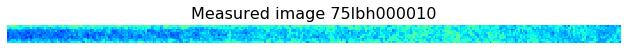

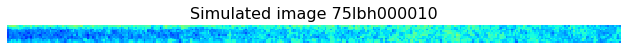

bubbles in channel: 76272, total runtime (min): 1.9, error (%): 2.65
--------------------------------------------------------------



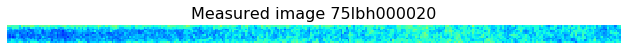

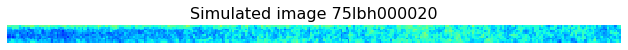

bubbles in channel: 76513, total runtime (min): 4.1, error (%): 2.61
--------------------------------------------------------------



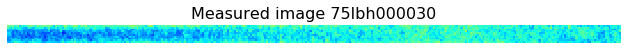

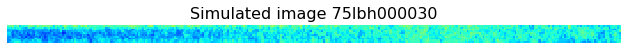

bubbles in channel: 76456, total runtime (min): 6.0, error (%): 2.71
--------------------------------------------------------------



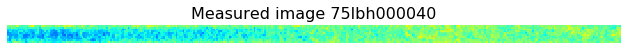

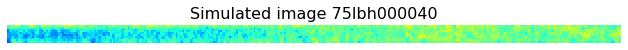

bubbles in channel: 78401, total runtime (min): 7.8, error (%): 2.87
--------------------------------------------------------------



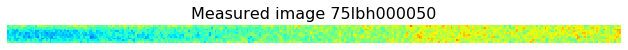

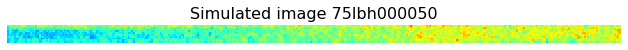

bubbles in channel: 79920, total runtime (min): 9.6, error (%): 2.81
--------------------------------------------------------------



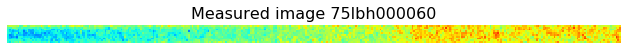

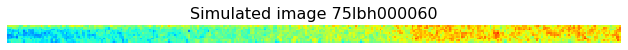

bubbles in channel: 80676, total runtime (min): 11.3, error (%): 2.87
--------------------------------------------------------------



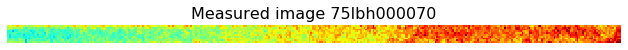

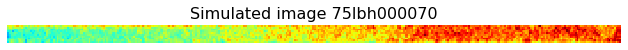

bubbles in channel: 83164, total runtime (min): 13.0, error (%): 2.94
--------------------------------------------------------------



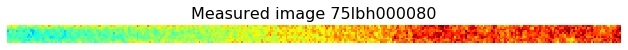

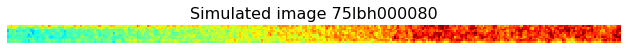

bubbles in channel: 82771, total runtime (min): 14.9, error (%): 2.91
--------------------------------------------------------------



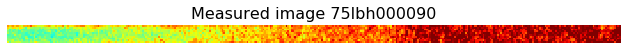

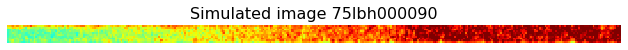

bubbles in channel: 83901, total runtime (min): 16.7, error (%): 3.0
--------------------------------------------------------------



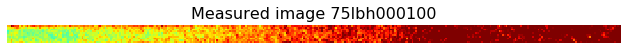

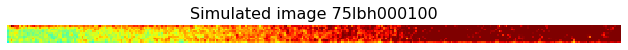

bubbles in channel: 83495, total runtime (min): 18.4, error (%): 2.94
--------------------------------------------------------------



In [16]:
starttime = time()

# loop over each image
for L in list(img_dict):

    # get target image to model
    measured_image = img_dict[L]['img_voidfrac']

    # get empty channel, list of its index coordinates, and bubbles
    channel_template, channel_coords = get_channel(measured_image.shape)
    min_rad = model_params['min_rad_um']/model_params['um_per_pixel']
    max_rad = model_params['max_rad_um']/model_params['um_per_pixel']
    bub_list = get_bubbles(measured_image,
                           num=model_params['num_of_bubbles_to_try'],
                           min_rad=min_rad,
                          max_rad=max_rad)

    # simulate empty channel to populate with simulated bubbles
    sim = {
        'label': L,
        'flowrate': img_dict[L]['flowrate'],
        'temp': img_dict[L]['temp'],
        'img_model': np.zeros_like(measured_image),
        'img_voidfrac': measured_image,
        'cent': [],
        'rad': []}
    
    # loop over each bubble to try in the model
    for i in range(len(bub_list['rad'])):

        # get z-profile of new bubble
        bub_profile = 2*np.sqrt(
            np.square(bub_list['rad'][i])
            - np.square(channel_coords[:, 0]-bub_list['x'][i])
            - np.square(channel_coords[:, 1]-bub_list['y'][i]))
        + model_params['buffer_um']/model_params['um_per_pixel']

        # convert nan to 0 and reshape to channel size
        bub_profile = np.where(
            np.isnan(bub_profile),
            0, bub_profile).reshape(sim['img_model'].shape)/model_params['d_um']

        # add new bubble to channel if it will fit
        if np.all(sim['img_model'] + bub_profile <= 1.02*sim['img_voidfrac']):
            sim['img_model'] += bub_profile
            sim['rad'].append(bub_list['rad'][i])
            sim['cent'].append([bub_list['x'][i], bub_list['y'][i]])

    # get total avg error between image and model
    tot_err = np.mean(np.abs((sim['img_model']-sim['img_voidfrac'])/sim['img_voidfrac']))*100
    sim['percent_error'] = round(tot_err, 2)
    
    # save model to file on local machine
    save_model_path = os.path.join(os.getcwd(), 'models', L + '__model.npy')
    np.save(save_model_path, sim)
    
    # show resultant matrix with bubbles
    plot_channel_image(sim['img_voidfrac'], title='Measured image '+L, vmin=0, vmax=1)
    plt.show()
    # show resultant matrix with bubbles
    plot_channel_image(sim['img_model'], title='Simulated image '+L, vmin=0, vmax=1)
    plt.show()

    print('bubbles in channel: {}, total runtime (min): {}, error (%): {}'.format(
        len(sim['rad']),
        round((time() - starttime)/60,1),
        round(tot_err, 2)))
    print('--------------------------------------------------------------\n')

## Examine the models that were saved

Models are saved to file in the *\models* directory.
Each model is saved as a Python dictionary and corresponds
to a particular channel image. The model includes:
* **label**: (filename) of the original channel image
* **img_model**: simulated channel image
* **img_voidfrac**: measured void fraction image
* **cent**: the centers of the simulated bubbles, in ordered pairs (x, y)
* **rad**: the radii of the simulated bubbles
* **percent_error**: total percent error between the measured channel image and the simulated channel image